In [21]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_colwidth", 200)
#from nltk.corpus import gutenberg
import re
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
from sklearn.datasets import fetch_20newsgroups

In [47]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
len(documents)

11314

In [24]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [50]:
news_df = pd.DataFrame({'document':documents})

# removing everything except alphabets`
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")

# removing short words
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [51]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# tokenization
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

news_df['clean_doc'] = detokenized_doc

In [52]:
news_df

,document,clean_doc
0,Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe...,well sure story seem biased disagree statement media ruin israels reputation rediculous media israeli media world lived europe realize incidences described letter occured media whole seem ignore s...
1,"\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism? No, you need a little leap of faith, Jimmy. Your logic runs out\nof steam!\n\n\n\n\n\n\n\nJim,\n...",yeah expect people read actually accept hard atheism need little leap faith jimmy logic runs steam sorry pity sorry feelings denial faith need well pretend happily ever anyway maybe start newsgrou...
2,"Although I realize that principle is not one of your strongest\npoints, I would still like to know why do do not ask any question\nof this sort about the Arab countries.\n\n If you want to conti...",although realize principle strongest points would still like know question sort arab countries want continue think tank charade fixation israel must stop might start asking sort questions arab cou...
3,"Notwithstanding all the legitimate fuss about this proposal, how much\nof a change is it? ATT's last product in this area (a) was priced over\n$1000, as I suspect 'clipper' phones will be; (b) ca...",notwithstanding legitimate fuss proposal much change last product area priced suspect clipper phones came customer automatically preregistered government authorities thus aside attempting legitimi...
4,"Well, I will have to change the scoring on my playoff pool. Unfortunately\nI don't have time right now, but I will certainly post the new scoring\nrules by tomorrow. Does it matter? No, you'll ...",well change scoring playoff pool unfortunately time right certainly post scoring rules tomorrow matter enter anyway good keith keller rangers quakers kkeller mail upenn league champs
...,...,...
11309,"Danny Rubenstein, an Israeli journalist, will be speaking tonight \n(Wednesday, 7:30 pm) on the messy subject of politics in Israel.\nHe is speaking at Hillel on the U.C. Berkeley campus. The tal...",danny rubenstein israeli journalist speaking tonight wednesday messy subject politics israel speaking hillel berkeley campus talk sponsored berkeley israel action committee
11310,\n,
11311,\nI agree. Home runs off Clemens are always memorable. Kinda like\neclipses and hurricanes. They don't happen very often.,agree home runs clemens always memorable kinda like eclipses hurricanes happen often
11312,"I used HP DeskJet with Orange Micros Grappler LS on System6.0.5.\n\nBut now I update system 6.0.5 to System7 with Kanji-Talk 7.1,\nthen I can not print by my DeskJet.\n\nIs the Grappler LS old ?\n...",used deskjet orange micros grappler system update system system kanji talk print deskjet grappler deskjet system please tell deskjet system thank


In [66]:
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.

vectorizer = TfidfVectorizer(stop_words='english',
max_features= 1000, # keep top 1000 terms 
max_df = 0.5, 
smooth_idf=True)

X=vectorizer.fit_transform(news_df['clean_doc'])

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=5


#this function resulted in NaNs for me, therefore I came up with another way to detect top_words
'''def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)'''

# Number of words to look at for each topic.
n_top_words = 10


In [67]:
X.shape # check shape of the document-term matrix

(11314, 1000)

In [29]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

<11314x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 250505 stored elements in Compressed Sparse Row format>

In [68]:
#LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_lsa = lsa.fit_transform(X)

components_lsa = word_topic(X, X_lsa, terms)

#topwords=pd.DataFrame()
#topwords['LSA']=top_words(components_lsa, n_top_words)     

In [73]:
#terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
like
 
know
 
people
 
think
 
good
 
time
 
thanks
 
Topic 1: 
thanks
 
windows
 
card
 
drive
 
mail
 
file
 
advance
 
Topic 2: 
game
 
team
 
year
 
games
 
season
 
players
 
good
 
Topic 3: 
drive
 
scsi
 
hard
 
disk
 
card
 
drives
 
controller
 
Topic 4: 
windows
 
file
 
window
 
files
 
program
 
using
 
version
 


In [76]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=5, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

X_lda = lda.fit_transform(X) 

components_lda = word_topic(X, X_lda, terms)

#topwords['LDA']=top_words(components_lda, n_top_words)
for i, comp in enumerate(lda.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
people
 
think
 
know
 
like
 
believe
 
time
 
jesus
 
Topic 1: 
thanks
 
windows
 
mail
 
know
 
file
 
program
 
card
 
Topic 2: 
government
 
people
 
clipper
 
encryption
 
public
 
chip
 
keys
 
Topic 3: 
drive
 
like
 
sale
 
scsi
 
hard
 
disk
 
price
 
Topic 4: 
game
 
year
 
team
 
games
 
bike
 
think
 
good
 


In [77]:
from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
X_nmf = nmf.fit_transform(X) 

components_nmf = word_topic(X, X_nmf, terms)

#topwords['NNMF']=top_words(components_nmf, n_top_words)

for i, comp in enumerate(nmf.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
people
 
think
 
like
 
time
 
know
 
right
 
good
 
Topic 1: 
windows
 
file
 
files
 
card
 
using
 
program
 
window
 
Topic 2: 
game
 
team
 
year
 
games
 
season
 
players
 
play
 
Topic 3: 
drive
 
scsi
 
hard
 
disk
 
drives
 
controller
 
floppy
 
Topic 4: 
thanks
 
know
 
mail
 
advance
 
looking
 
email
 
info
 


# Sparsity

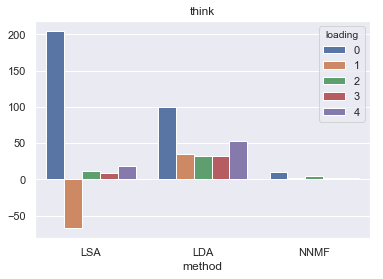

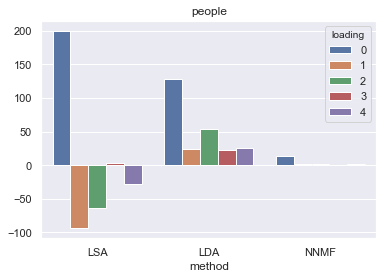

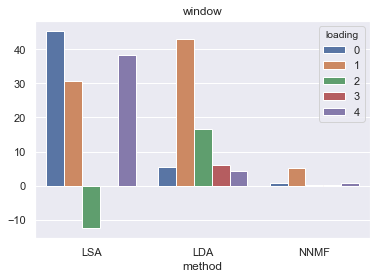

In [80]:
# The words to look at.
targetwords=['think','people', 'window']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()


### LSA has highest loading for any word but also has negative loadings. LDA, does not have any negative loadings at all. NNMF did poorly in showing sparsity. 